In [ ]:
def lower_bound(p, f, D, N):
    '''
    p = variational parameters
    f = log functions
    D = dataset
    N = number of samples
    '''
    mu, cov = p[:D], np.exp(p[:D])
    samples = npr.randn(N,D)*np.sqrt(cov)+mu
    result = mvn.entropy(mu, np.diag(cov))+np.mean(logprob(samples))
    
    return result



# Mean Field Variational Bayes


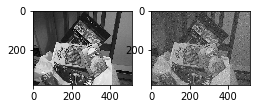

In [13]:
import numpy as np 
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
from scipy.misc import imread
from scipy.special import expit as sigmoid
from scipy.stats import multivariate_normal

def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im).astype('float')
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2
   
prop = 0.5
# prop: percentage of images to alter (parameter for both noise mask), prop = 1 --> 100% colour inversion for saltnpeppar noise.
varSigma = 0.1
# varSigma = standard deviation parameter for Gaussian noise, low varSigma --> smoother noise spread.

im = imageio.imread('./figures/test.png')
im = im/255
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
# im3 = add_saltnpeppar_noise(im,prop)
# ax3 = fig.add_subplot(133)
# ax3.imshow(im3,cmap='gray')


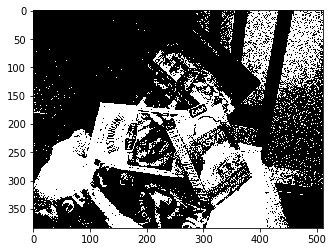

In [14]:
# img = np.double(im2)
# img_mean = np.mean(img)
# img_binary = +1*(img>img_mean) + -1*(img<img_mean)
# [M,N] = img_binary.shape
# plt.imshow(img_binary, cmap='gray')

img_gray_arr = np.asarray(im2)
x = np.rint(img_gray_arr)
img_mean = np.mean(x)
img_arr = np.copy(x)
img_arr[x<img_mean] = -1
img_arr[x>=img_mean] = 1
plt.imshow(img_arr, cmap='gray')
[M,N] = img_arr.shape


100%|██████████| 10/10 [01:18<00:00,  7.87s/it]


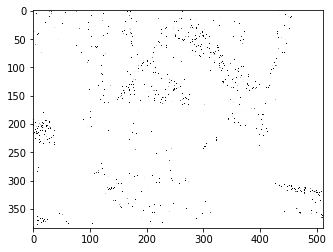

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Farrel\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Farrel\Anaconda3\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Farrel\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Farrel\Anaconda3\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in c

In [16]:

J = 1  #coupling strength (w_ij)
prop = 0.5  #update smoothing rate
sigma  = 0.1  #noise level
max_iter = 10
ELBO = np.zeros(max_iter)
Hx_mean = np.zeros(max_iter)

logodds = multivariate_normal.logpdf(im2.flatten(), mean=+1, cov=sigma**2) - \
          multivariate_normal.logpdf(im2.flatten(), mean=-1, cov=sigma**2)
logodds = np.reshape(logodds, (M, N))

#init
p1 = sigmoid(logodds)
mu = 2*p1-1  #mu_init

a = mu + 0.5 * logodds
qxp1 = sigmoid(+2*a)  #q_i(x_i=+1)
qxm1 = sigmoid(-2*a)  #q_i(x_i=-1)

logp1 = np.reshape(multivariate_normal.logpdf(im2.flatten(), mean=+1, cov=sigma**2), (M, N))
logm1 = np.reshape(multivariate_normal.logpdf(im2.flatten(), mean=-1, cov=sigma**2), (M, N))

for i in tqdm(range(max_iter)):
    muNew = mu
    for ix in range(N):
        for iy in range(M):
            pos = iy + M*ix
            neighborhood = pos + np.array([-1,1,-M,M])            
            boundary_idx = [iy!=0,iy!=M-1,ix!=0,ix!=N-1]
            neighborhood = neighborhood[np.where(boundary_idx)[0]]            
            xx, yy = np.unravel_index(pos, (M,N), order='F')
            nx, ny = np.unravel_index(neighborhood, (M,N), order='F')
            
            Sbar = J*np.sum(mu[nx,ny])       
            muNew[xx,yy] = (1-prop)*muNew[xx,yy] + prop*np.tanh(Sbar + 0.5*logodds[xx,yy])
            ELBO[i] = ELBO[i] + 0.5*(Sbar * muNew[xx,yy])
        #end for
    #end for
    mu = muNew
            
    a = mu + 0.5 * logodds
    qxp1 = sigmoid(+2*a) #q_i(x_i=+1)
    qxm1 = sigmoid(-2*a) #q_i(x_i=-1)    
    Hx = -qxm1*np.log(qxm1+1e-10) - qxp1*np.log(qxp1+1e-10) #entropy        
    
    ELBO[i] = ELBO[i] + np.sum(qxp1*logp1 + qxm1*logm1) + np.sum(Hx)
    Hx_mean[i] = np.mean(Hx) 

plt.imshow(mu, cmap='gray')